In [1]:
%reset -f
%matplotlib inline
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from disaggregator import config, data, plot

# Importing the data

We import the raw data (points in a matrix), and simplify them into districts. We can then store them as different data sets to reduce the size.

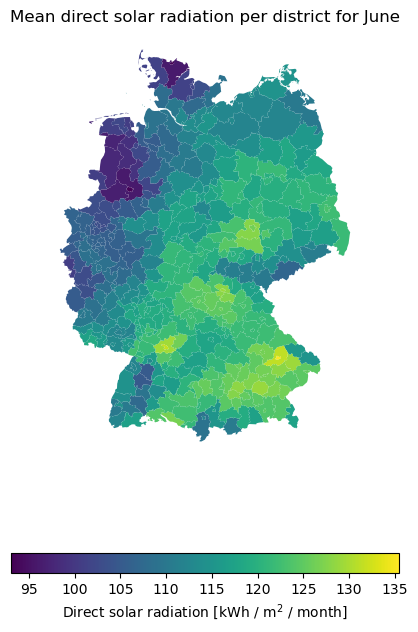

In [2]:
for m in range(1, 13):
    gdf = gpd.read_file(f"project_data/in/WeatherData/in/radiation_2022_{m:02}.geojson") # Import the given solar irradiation as points for month m
    
    # Convert from EPSG:31467 to EPSG:25832
    gdf.crs = "EPSG:31467"
    gdf = gdf.to_crs("EPSG:25832")
    
    nuts = data.database_shapes().drop(columns = ["id_ags", "gen", "fl_km2"]) # Import the nuts3 data and delete useless columns
    
    result = gpd.sjoin(gdf, nuts, how="left").dropna(subset=['index_right'])
    
    # Group the result by nuts3 region and compute the mean and standard deviation of the data
    grouped = result.groupby('index_right')['value'].agg(['mean', 'std']).reset_index()
    grouped.rename(columns = {"index_right": "nuts3", "mean": "mean_irr", "std": "std_irr"}, inplace = True)
    
    shapes_with_stats = nuts.merge(grouped, on='nuts3', how='left')
    
    fig, ax = plt.subplots(figsize=(10, 8))
    shapes_with_stats.plot(column='mean_irr', cmap='viridis', legend=True, ax=ax, legend_kwds={
        "shrink":.5, 'label': "Direct solar radiation [kWh / m$^2$ / month]", 'orientation': "horizontal"})
    plt.title(f"Mean Radiation by NUTS3 Region for {m:02} month")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title("Mean direct solar radiation per district for June")
    plt.axis('off')
    plt.show()
    #plt.savefig("project_data/out/Images/07_03_methodology_solar_irradiation.png", dpi = 300, transparent = True, bbox_inches = 'tight')
    
    shapes_with_stats.to_file(f"project_data/in/WeatherData/out/radiation_2022_{m:02}.geojson", driver='GeoJSON')

# Further reducing the size

Instead of having 12 files giving 12 dataframes, we can hold all the data in one single dataframe. Instead of having integers, there will be a list

In [22]:
mean_values_list = []
std_values_list = []

for m in range(1, 13):
    gdf = gpd.read_file(f"project_data/in/WeatherData/out/radiation_2022_{m:02}.geojson")
    
    mean_values_list.append(gdf["mean_irr"].values.tolist())
    std_values_list.append(gdf["std_irr"].values.tolist())

# Stack the lists of arrays vertically to create a 2D array
mean_values = np.vstack(mean_values_list).T
std_values = np.vstack(std_values_list).T

# Get all the values for a same district for a year
mean_values = [row for row in mean_values]
std_values = [row for row in std_values]

nuts = data.database_shapes().drop(columns = ["id_ags", "gen", "fl_km2"]) # Import the nuts3 data and delete useless columns

nuts["mean_irr"] = list(mean_values)
nuts["std_irr"] = list(std_values)

# Convert NumPy arrays to lists before saving to GeoJSON
nuts["mean_irr"] = nuts["mean_irr"].apply(lambda x: str(x.tolist()))
nuts["std_irr"] = nuts["std_irr"].apply(lambda x: str(x.tolist()))

nuts.head()
nuts.to_file("project_data/in/WeatherData/weatherData_2022.geojson", driver='GeoJSON')

# Example of how to open the file

In [4]:
nuts = gpd.read_file("project_data/in/WeatherData/weatherData_2022.geojson").drop(columns = "geometry")

nuts["mean_irr"] = nuts["mean_irr"].apply(lambda x: json.loads(x))
nuts["std_irr"]  = nuts["std_irr"].apply(lambda x: json.loads(x))

nuts.head()

,nuts3,mean_irr,std_irr
0,DE111,"[12.947962085308056, 28.988862559241703, 76.04...","[1.008702664427085, 0.7353098699389284, 0.6325..."
1,DE112,"[14.930658105939004, 29.198876404494385, 74.24...","[0.9284929099810908, 0.8982541243088454, 0.926..."
2,DE113,"[14.731011058451816, 29.061595576619276, 78.27...","[1.1882041236397383, 1.089408654238516, 0.8752..."
3,DE114,"[14.036507936507936, 26.150539682539684, 78.67...","[0.8121117318206648, 1.1865400506285204, 1.064..."
4,DE115,"[10.229955817378498, 26.00743740795287, 74.579...","[0.9973823399119949, 1.126591657464849, 1.4309..."


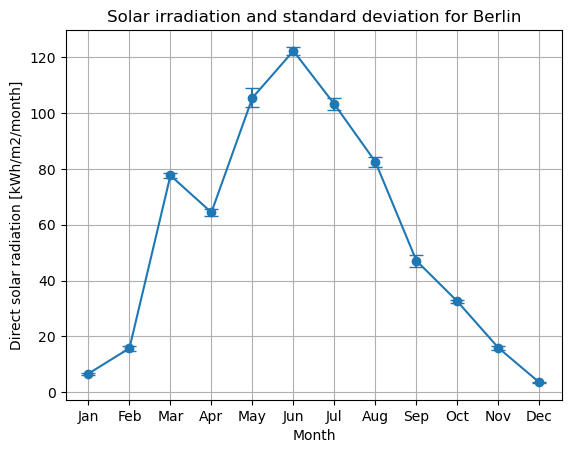

In [21]:
district = "DE40G"

mean = list(nuts[nuts["nuts3"] == district]["mean_irr"].values)[0]
std = list(nuts[nuts["nuts3"] == district]["std_irr"].values)[0]

# Plotting
plt.errorbar(range(len(mean)), mean, yerr=std, fmt='o-', capsize=5)

plt.xlabel('Month')
plt.ylabel('Direct solar radiation [kWh/m2/month]')
plt.title('Solar irradiation and standard deviation for Berlin')

plt.xticks(range(len(mean)), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.grid()
plt.show()

## Price as a function of solar power installed

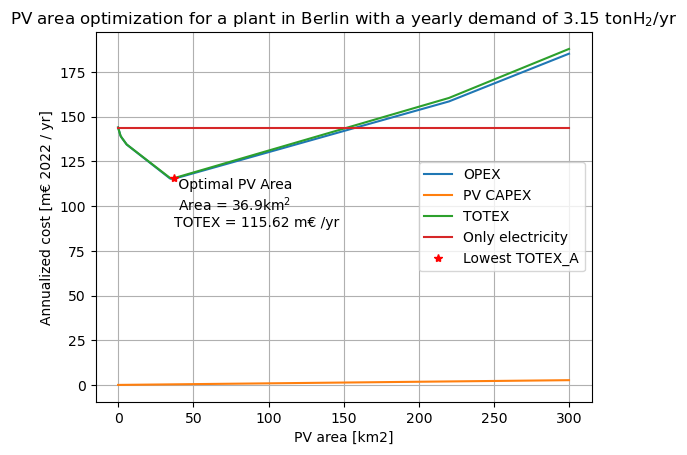

In [52]:
district = "DE300"

mean = list(nuts[nuts["nuts3"] == district]["mean_irr"].values)[0]

Ptot = 1.5e8 # kWh / yr

heating_profile = [
    0.21,  # January
    0.22,  # February
    0.15,  # March
    0.02,  # April
    0.01,  # May
    0.01,  # June
    0.00,  # July
    0.00,  # August
    0.00,  # September
    0.07,  # October
    0.15,  # November
    0.16   # December
]

P = [12 * Ptot * load for load in heating_profile]

eta = 0.1 # - solar efficiency
maxArea = Ptot / eta / 5 # m2
Areas = np.arange(0, maxArea, maxArea/1000) # m2

n = 25 # yr lifetime of PV
i = 0.05 # - interest
tau = i*(1+i)**n / ( (1+i)**n - 1) # - return on investment

solar_irr = 1 # kW

Cop = 0.08 # $/kWh

Cmant = 3.84/12 # $/kWp/month
Cap = 1.25 # $/kWp

OPEX_A = []
CAPEX_A = []

TOTEX_A = []

for A in Areas:
    Pinst = eta*solar_irr*Cap*A # kWp Installed power
    
    OPEX_t = [Cop * max(P[t] - mean[t]*A*eta, 0) + Cmant*Pinst for t in range(12)]    # OPerational costs
    CAPEX = tau*Pinst                                                                 # CAPital costs
    
    TOTEX = sum(OPEX_t) + CAPEX
    
    OPEX_A.append(sum(OPEX_t))
    CAPEX_A.append(CAPEX)
    TOTEX_A.append(TOTEX)


plt.plot([a / 1e6 for a in Areas], [c / 1e6 for c in OPEX_A], label="OPEX")
plt.plot([a / 1e6 for a in Areas], [c / 1e6 for c in CAPEX_A], label="PV CAPEX")
plt.plot([a / 1e6 for a in Areas], [c / 1e6 for c in TOTEX_A], label="TOTEX")

plt.plot([a / 1e6 for a in Areas], 12 * Ptot * Cop * np.ones(len(TOTEX_A)) / 1e6, label="Only electricity")

plt.title(f"PV area optimization for a plant in Berlin with a yearly demand of {Ptot*0.7/33.33/1e6:.2f} tonH$_2$/yr")
plt.xlabel("PV area [km2]")
plt.ylabel("Annualized cost [m€ 2022 / yr]")

# Find the index and values for the lowest TOTEX_A
min_totex_index = TOTEX_A.index(min(TOTEX_A))
min_totex_value = TOTEX_A[min_totex_index]
corresponding_area = Areas[min_totex_index]

plt.plot(corresponding_area / 1e6, min_totex_value / 1e6, 'r*', label="Lowest TOTEX_A")

# Adding text to the plot for the lowest TOTEX_A point
plt.text(corresponding_area / 1e6, min_totex_value / 1e6,
         f" Optimal PV Area\nArea = {corresponding_area/1e6}km$^2$\nTOTEX = {min_totex_value/1e6:.2f} m€ /yr", 
         horizontalalignment='left', verticalalignment='top')


plt.legend(loc="center right")
plt.grid()

#plt.savefig("project_data/out/Images/07_07_pv_area_optimization.png", dpi = 300, transparent = True, bbox_inches = 'tight')

# Heat load profile

Since we are modeling to the detail the solar power as a function of time, we should also model the gas demand demand as a function of the month and the district.

Data source : https://zenodo.org/records/3404147 (used in https://www.sciencedirect.com/science/article/pii/S0306261919318483)

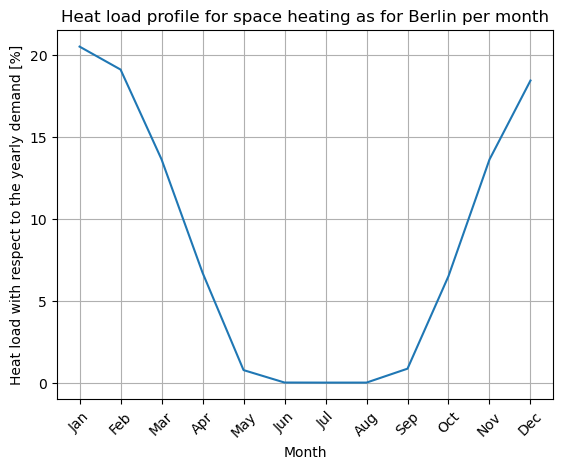

In [14]:
data = pd.read_csv('project_data/in/HeatLoadProfile/SH_profile.csv', index_col='nuts3')

periods = [col for col in data.columns if col.startswith('Period')]

# Mapping periods to months of the year

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plotting

for nuts3, row in data.iterrows():
    if nuts3 != 'DE300': continue
    plt.plot(range(12), row[periods] * 100, label=nuts3)

plt.xlabel('Month')
plt.ylabel('Heat load with respect to the yearly demand [%]')
plt.title('Heat load profile for space heating as for Berlin per month')

plt.xticks(range(12), months, rotation=45)  # Set months as x-axis ticks

plt.grid()

plt.savefig("project_data/out/Images/05_04_heat_profile.png", dpi = 300, transparent = True, bbox_inches = 'tight')

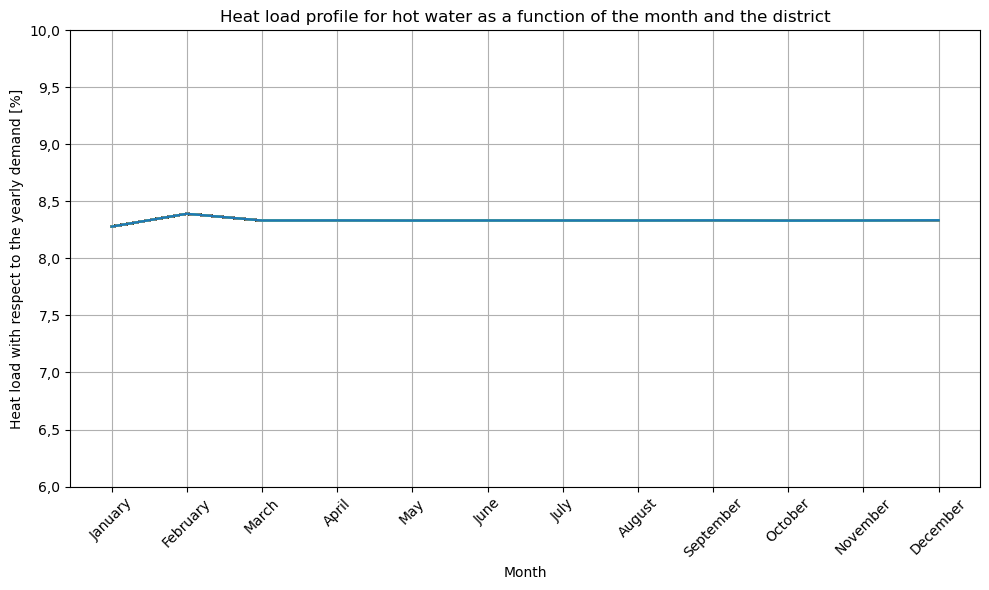

In [5]:
data = pd.read_csv('project_data/in/HeatLoadProfile/DHW_profile.csv', index_col='nuts3')

periods = [col for col in data.columns if col.startswith('Period')]

# Mapping periods to months of the year
months = {
    "Period 1": "January",
    "Period 2": "February",
    "Period 3": "March",
    "Period 4": "April",
    "Period 5": "May",
    "Period 6": "June",
    "Period 7": "July",
    "Period 8": "August",
    "Period 9": "September",
    "Period 10": "October",
    "Period 11": "November",
    "Period 12": "December"
}

# Plotting
plt.figure(figsize=(10, 6))
for nuts3, row in data.iterrows():
    plt.plot(periods, row[periods] * 100, label=nuts3)  # Multiply by 100 for percentage

plt.xlabel('Month')
plt.ylabel('Heat load with respect to the yearly demand [%]')
plt.title('Heat load profile for hot water as a function of the month and the district')

plt.ylim([6, 10])
plt.xticks(periods, [months[period] for period in periods], rotation=45)  # Set months as x-axis ticks

plt.grid()
plt.tight_layout()
plt.show()